In [34]:
import numpy as np
from numpy import random
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
import math, decimal
from math import exp
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from xgboost import XGBClassifier
from collections import Counter
seedRF = 50

In [6]:
train = pd.read_csv("train.csv", index_col = None)
y = train[['LABELS']]
x = train.drop('LABELS', axis=1)
xMean = x.mean()
test_nolabels = pd.read_csv("test_nolabels.csv", index_col = None)

In [7]:
# Splitting trainig/Validation
x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)

## Replacing possible missing values
x_train = x_train.fillna(xMean)
x_validation = x_validation.fillna(xMean)

In [ ]:
## Data shape exploration
print("",np.shape(x_train),"  :",np.shape(x_validation) )
print("Label balance on Training set: ", "\n", y_train['LABELS'].value_counts())
print("Label balance on Validation set: ", "\n", y_validation['LABELS'].value_counts())

In [80]:
# To adapt the prediction to Kaggel format of submission 
def formating_prediction(predictions): 
        '''
        return de predicted classes from the hypotesis function result (sigmoid(W,X))
        @hypotesis : matrix of probablilities 
        '''
        y_hat = pd.DataFrame({'S.No' : [],'LABELS' : []}, dtype=np.int8) 
        for i in range(len(predictions)):
            y_hat.loc[i] = [i,predictions[i]]
        return pd.DataFrame(data = y_hat) 

In [12]:
# feature extraction based on domain knowledge (In progress)
ndvi_list = {'NDVI_jan','NDVI_feb','NDVI_mar','NDVI_apr','NDVI_may','NDVI_jun','NDVI_jul','NDVI_aug','NDVI_sep','NDVI_oct','NDVI_nov','NDVI_dec'}
## Extrae los NDVI y escatter contra las labels

In [16]:
### Some helpers function
def predictOnSet(modelFilename, x_test):
        # # load the model from disk to predict new dataSet
    loaded_model = pickle.load(open(modelFilename, 'rb'))
    prediction = rf_classifier.predict(x_test)
    return prediction

def savingModels(classifier, modelFileName):
    '''
    NOTE: Do not forget the extention = *.pkl
    Save as : 'modelFileName.pkl'
    '''
    joblib.dump(classifier, modelFileName)


def importModel(modefname):
    model = pickle.load(open(modefname,'rb'))
    return model

def savePrediction(prediction, filename):
    '''
    Save predictions
    @argument: filename: Remenber EXTENTION 'filename.csv'
    '''
    prediction = prediction.astype('int32') #exsure prediction as integer
    predictions_DF = formating_prediction(prediction)
    return predictions_DF.to_csv(filename, index = None)



In [47]:
## modle evaluation
def metric_RocAuc(y_probability, y_validation, estimator_name):
    '''
    Calculate and plt ROC metric
    @argument: y_probability : the probability class=1.
    @argument: y_validation: True labels.
    fpr, tpr = false_positive, true_positive.
    Return: "false_positive" and "true_positive", ROC_auc metric.
    '''
    fpr, tpr, _ = roc_curve(y_validation, y_probability) 
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(constrained_layout=True,figsize=(5,3), dpi=150)
    fig.suptitle(estimator_name)
    axes.plot([0, 1], [0, 1], color= 'k',linestyle="--") # perfect fit 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot(ax=axes)
    return fpr, tpr, roc_auc

## Show some evaluation criteria on the clasifier
def evaluate_model(x_train, y_train, x_validation, y_validation, classifier):
    features = x_train.columns
    validation_Prediction = classifier.predict(x_validation)
    validation_PredictedProb = classifier.predict_proba(x_validation)[:, 1]
    ### ROC metric and curve #####
    clasifierName = type(classifier).__name__
    metric_RocAuc(validation_PredictedProb, y_validation,clasifierName)
    fi_model = pd.DataFrame({'feature': features,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)     

    return fi_model

In [1]:
## XGBOOST
def xgboost(X_train, y_train, x_validation, y_validation):    
    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(x_validation)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_validation, predictions)
    print("Accuracy xgboost: %.2f%%" % (accuracy * 100.0))
    predictionsDF = formating_prediction(predictions)
    return model, accuracy, predictionsDF

In [83]:
# Random Forest 
def randomForest(x_train, y_train, x_validation, y_validation, estimators):
    '''
    Performe random forest, in the simples way, from Skl library
    @estimators: NUmber of estimators
    return: model "classifier_LR" and a prediction over a x_validation
    '''
    y_train = np.array(y_train)
    y_train =  y_train.ravel()#np.reshape(y_train,(-1,1))
    rf_classifier = RandomForestClassifier(n_estimators = estimators, criterion = 'entropy', random_state = 42)
    rf_classifier.fit(x_train, y_train)

    # Predicting on the validation set
    prediction = rf_classifier.predict(x_validation)
    accuracy = accuracy_score(y_validation, prediction)
    prediction = prediction.astype('int32')
    savingModels(rf_classifier, "rf_simple.pkl")
    ### Comment/Uncomment next line to save prediction on ValidationSet as *.csv
    # savePrediction(prediction, "rf_validatoinPredicted.csv")
    predictions_DF = formating_prediction(prediction)
    return rf_classifier, accuracy, predictions_DF 


In [84]:
#### Ramdomized RF  ####
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(100, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seedRF)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seedRF)


In [ ]:
# Random searsh  
y_train = np.array(y_train).ravel()
rs.fit(x_train, y_train)
print(rs.best_params_, "\n")

In [ ]:
### Working with best estimator from RandomizedSearch 
best_model = rs.best_estimator_
savingModels(best_model, "rf_RandomSearch.pkl")

test_nolabels_prediction = predictOnSet(best_model, test_nolabels)
savePrediction(test_nolabels_prediction, 'first_rfSearch_noLabelPrediction.csv')

fi_model = evaluate_Rf(x_train, y_train, x_validation, y_validation, test_nolabels_prediction)

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}', '\n')
print(f'Average maximum depth {int(np.mean(max_depths))}')



,feature,importance
176,ERA5_temperature_2m_oct,0.042421
14,ERA5_temperature_2m_jan,0.039971
142,topo_elevation_aug,0.037996
212,ERA5_temperature_2m_dec,0.037002
196,topo_elevation_nov,0.032995
...,...,...
25,S2_B8_feb,0.000173
61,S2_B8_apr,0.000137
6,S2_B7_jan,0.000130
27,S2_B9_feb,0.000000


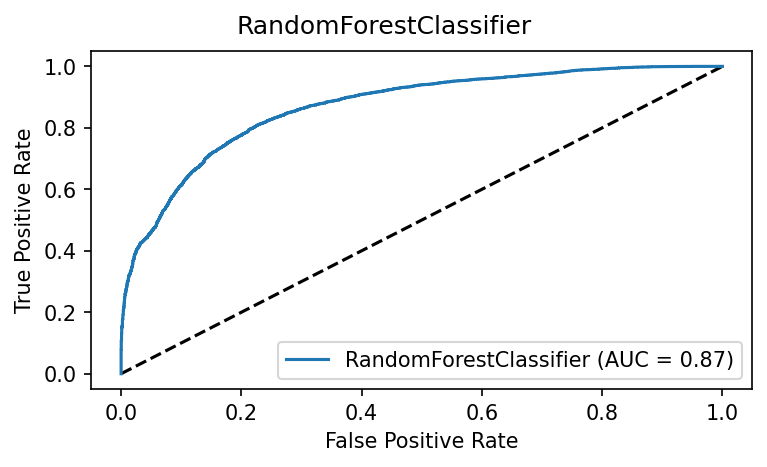

In [48]:

classifier = joblib.load("rf_RandomSearch.pkl")
# print(classifier)
evaluate_model(x_train, y_train, x_validation, y_validation, classifier)

In [ ]:
# predict and format prediction
rf_classifier, accuracy, predictions_DF 

In [ ]:
# Save model and sve predisction
